In [2]:
from langgraph.graph import StateGraph, START , END
from typing import TypedDict, Annotated , List
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
import requests
from pathlib import Path
import operator
from pydantic import BaseModel, Field
from typing import Literal, Tuple , Union
from langchain_mistralai import ChatMistralAI
from langgraph.types import Send
import re
from langchain_community.tools import DuckDuckGoSearchRun
import os
from langchain.agents import create_agent

key = "N56JL9JhomtYzc64dQh7K05t6m0G8u9Q"

model = ChatMistralAI(
    model="mistral-large-2512",
    mistral_api_key= key,  # Direct key
    temperature=0.7
)

In [3]:
search_tool = DuckDuckGoSearchRun(region="us-en")

In [4]:
agent = create_agent(model = model, tools= [search_tool])

First we have to make a share memory of workflow which is state.

In [5]:
class task(BaseModel):
    task_id : int 
    task_name : Annotated[str, Field(..., description= "Task name")]
    task_description : Annotated[str, Field(..., description= "What you have to cover in the task.")]
    

In [6]:
class Plan(BaseModel): 
    """Plan to follow in future"""
    tasks : Annotated[List[task], Field(...,description= "different tasks to follow, should be in sorted order")]

In [7]:
class Response(BaseModel):
    response : str 

In [8]:
class replan(BaseModel):
    action : Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan. If the plan is completely executed use Response to give response" 
    )


In [9]:
model_with_structure_replan = model.with_structured_output(replan)

In [10]:
model_with_structure_response = model.with_structured_output(Plan)

In [11]:
class State(TypedDict):
    user_input : str 
    plan : Plan
    previous_executed_steps : Annotated[List[Tuple],operator.add]
    response : str

Now we have both Planning pydantic schema and Replanning pydantic shema so now our model can give us strcuture reponse means we have control of our model response. 

In [12]:
def set_planner(State : State):
    #Now design system prompts for our both schemas 
    plan = model_with_structure_response.invoke([SystemMessage(content =f"""For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""),
    HumanMessage(content=f"""{State["user_input"]}""")])

    return {"plan" : plan}

In [13]:
def executor(State : State):
    plan = State["plan"]
    task = plan.tasks[0]
    task_formatted = f"""For the following plan:{plan}\n\nYou are tasked with executing task {task}"""
    agent_response = agent.invoke({"messages": [("user", task_formatted)]})
    return {"previous_executed_steps": [(task, agent_response["messages"][-1].content)]}

In [14]:
def replanner(State: State):
    replan =f"""For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

    Your objective was this:
    {State["user_input"]}

    Your original plan was this:
    {State["plan"]}

    You have currently done the follow steps:
    {State['previous_executed_steps']}
    the tasks which are done should be removed from the plan. So update the plan {State['plan']}

    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
    plan = model_with_structure_replan.invoke(replan)
    if isinstance(plan.action ,Response):
        return {"response": plan.action.response } 
    else: 
        return {"plan" : plan.action}

In [15]:
def condition(State : State):
    if "response" in State and State["response"]:
        return END
    else: 
        return "executor"

In [16]:
graph = StateGraph(State)

#Lets make nodes 

graph.add_node("planner", set_planner)
graph.add_node("executor", executor)
graph.add_node("replanner",replanner)

graph.add_edge(START, "planner")
graph.add_edge("planner", "executor")
graph.add_edge("executor","replanner")
graph.add_conditional_edges("replanner", condition ,["executor",END])

workflow = graph.compile()

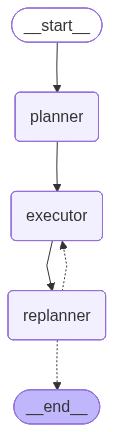

In [20]:
workflow

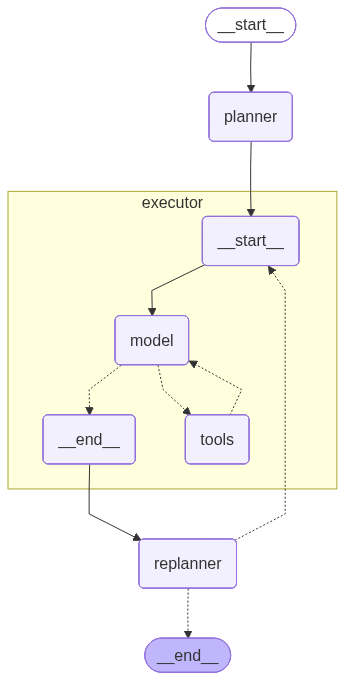

In [21]:
from IPython.display import Image, display

display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

In [18]:
result = workflow.invoke({"user_input":"Who is the the popular political leader in pakistan ?, Write his achievments in life  ?"})

In [19]:
result 

{'user_input': 'Who is the the popular political leader in pakistan ?, Write his achievments in life  ?',
 'plan': Plan(tasks=[task(task_id=2, task_name='Verify Information Accuracy', task_description="Cross-check all compiled information about Imran Khan's basic details, political achievements, and non-political achievements with reliable and up-to-date sources. Ensure the following:\n1. **Basic Information**: Confirm date of birth, educational background, and political party affiliation.\n2. **Political Achievements**: Verify the accuracy of policies, reforms, and initiatives listed under his political career, including dates, impacts, and outcomes.\n3. **Non-Political Achievements**: Validate details about his cricket career, philanthropic work (e.g., Shaukat Khanum Hospital, Namal University), and authored books.\n4. Correct any discrepancies, outdated information, or errors found during verification."), task(task_id=3, task_name='Write the Final Answer', task_description="Combine 

In [ ]:
result 

{'user_input': 'Plan a trip to newyork city 5000$ budget book hotel book cab book ride plan it for 7 days and also plan breakfast dinner and vsit place for each day',
 'plan': Plan(tasks=[task(task_id=1, task_name='Calculate Daily Budget', task_description='Divide the total budget of $5000 by 7 days to determine the daily budget. Allocate funds for accommodation, food, transportation, and activities. Ensure the breakdown aligns with the confirmed trip dates and prioritizes essential expenses like hotel and local transportation.'), task(task_id=2, task_name='Research and Select Accommodation', task_description='Research hotels within the budget of $150-$250 per night for the confirmed dates (e.g., October 10–16, 2024). Prioritize locations in Manhattan or nearby areas (e.g., Brooklyn, Queens) with good reviews and amenities. Select a hotel and book it for 7 nights.'), task(task_id=3, task_name='Book Transportation to New York City', task_description='Book flights or train tickets to New

In [53]:
result 

{'user_input': 'Plan a trip to newyork city 5000$ budget book hotel book cab book ride plan it for 7 days and also plan breakfast dinner and vsit place for each day',
 'plan': Plan(tasks=[task(task_id=3, task_name='Research and Book Accommodation', task_description='Search for hotels or Airbnb options in NYC within the $300/night budget. Prioritize locations in Manhattan, Brooklyn, or areas near major tourist attractions (e.g., Times Square, Central Park, or Downtown Brooklyn). Compare prices, read reviews, and check for amenities like free cancellation, Wi-Fi, and breakfast. Finalize and book accommodation for 7 nights, ensuring the total cost does not exceed $2,100.'), task(task_id=4, task_name='Plan and Book Transportation', task_description='1. **Airport Transfer**: Book a cab or rideshare (Uber/Lyft) for the arrival day from the airport to the hotel. Estimate the cost and ensure it fits within the $500 transportation budget.\n2. **Local Transportation**: Plan daily transportation 

In [ ]:
result

{'user_input': 'What is Agentic Ai, What is planning in agentic ai, What is adaptability in agntic ai , What is ai ',
 'plan': Plan(tasks=[task(task_id=2, task_name='Explain Planning in Agentic AI', task_description="Describe what 'planning' means in the context of Agentic AI. Include its role, importance, and how it enables Agentic AI to achieve goals. Provide examples to illustrate how planning works in real-world scenarios, such as autonomous systems or decision-making frameworks."), task(task_id=3, task_name='Explain Adaptability in Agentic AI', task_description="Define 'adaptability' in Agentic AI. Explain how Agentic AI systems adjust their actions based on changing environments or new information. Include real-world examples or use cases, such as robotics, healthcare, or customer service, to demonstrate adaptability."), task(task_id=4, task_name='Define Artificial Intelligence (AI)', task_description='Provide a clear and concise definition of Artificial Intelligence (AI). Includ

In [ ]:
result

{'user_input': 'Plan a full fledge trip to newyork city',
 'plan': Plan(tasks=[task(task_id=2, task_name='Set a Budget', task_description='Determine the total budget for the trip to New York City, broken down into the following categories:\n  - Flights: Include round-trip airfare, baggage fees, and airport transfers.\n  - Accommodation: Calculate the total cost for the entire duration of the stay (hotel, Airbnb, or other lodging).\n  - Food: Estimate daily food expenses (breakfast, lunch, dinner, snacks) and include a buffer for fine dining or unexpected meals.\n  - Transportation: Include costs for subway passes (e.g., MetroCard), taxis, rideshares (Uber/Lyft), and any intercity travel (e.g., trains to nearby cities).\n  - Activities: List all pre-booked activities (e.g., Broadway shows, museum tickets, guided tours) and estimate costs for spontaneous activities.\n  - Miscellaneous: Allocate funds for souvenirs, tips, emergency expenses, and unexpected costs.\n  - Ensure the budget al